In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import clear_output
# import untils
# from COBWEBNN import CobwebNN, CobwebNNTreeLayer, TestModel
from encoder_decoder.resnet_encoder import Encoder, BasicBlockEnc
from encoder_decoder.restnet_decoder import Decoder, BasicBlockDec

torch.Size([1, 1, 28, 28]) tensor([2])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    

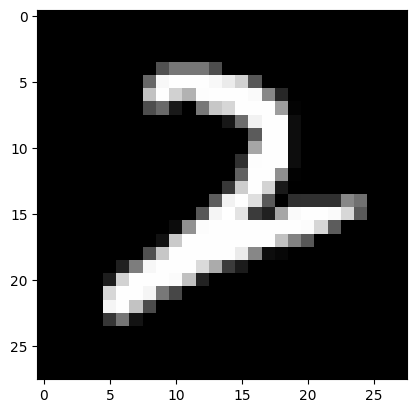

In [3]:
download = False
dataset_class = datasets.MNIST
mnist_transform = [transforms.ToTensor()]
# add normalization to the transform list such that all values are strictly greater than 0
# mnist_transform.append(transforms.Lambda(lambda x: x + 1e-5))
# normalize the data
# mnist_transform.append(transforms.Normalize((0.1307,), (0.3081,)))

dataset_transform = transforms.Compose(mnist_transform)
mnist_train = dataset_class('data/MNIST', train=True, download=download, transform=dataset_transform)
mnist_test = dataset_class('data/MNIST', train=False, download=download, transform=dataset_transform)

mnist_train_loader = DataLoader(mnist_train, batch_size=1, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(mnist_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    plt.imshow(data[0, 0].numpy(), cmap='gray')
    plt.show()
    break

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# randonly shuffle the training data
mnist_train_loader = DataLoader(mnist_train, batch_size=8, shuffle=True)

torch.Size([1, 3, 32, 32]) tensor([8])
tensor([[[[0.8314, 0.8431, 0.8627,  ..., 0.8235, 0.8275, 0.8353],
          [0.8196, 0.8275, 0.8392,  ..., 0.8000, 0.8039, 0.8078],
          [0.8275, 0.8314, 0.8431,  ..., 0.7961, 0.8039, 0.8039],
          ...,
          [0.7333, 0.7255, 0.4118,  ..., 0.9020, 0.9137, 0.9176],
          [0.7569, 0.7569, 0.7137,  ..., 0.9137, 0.9216, 0.9373],
          [0.8588, 0.8588, 0.8706,  ..., 0.9255, 0.9373, 0.9451]],

         [[0.8667, 0.8745, 0.8863,  ..., 0.8549, 0.8627, 0.8706],
          [0.8549, 0.8549, 0.8627,  ..., 0.8314, 0.8353, 0.8431],
          [0.8588, 0.8588, 0.8627,  ..., 0.8275, 0.8353, 0.8314],
          ...,
          [0.7451, 0.6902, 0.3137,  ..., 0.9020, 0.9176, 0.9255],
          [0.7529, 0.7490, 0.6980,  ..., 0.9137, 0.9216, 0.9412],
          [0.8588, 0.8667, 0.8824,  ..., 0.9373, 0.9529, 0.9686]],

         [[0.8745, 0.8824, 0.8980,  ..., 0.8627, 0.8627, 0.8627],
          [0.8706, 0.8745, 0.8824,  ..., 0.8431, 0.8431, 0.8431],
   

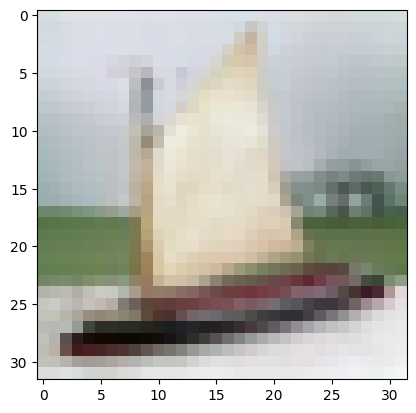

In [4]:
# load CIFAR10
download = False
dataset_class = datasets.CIFAR10
cifar10_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], 
                        #  std=[0.247, 0.243, 0.261])
])

# dataset_transform = transforms.Compose(cifar10_transform)
cifar10_train = dataset_class('data/CIFAR10', train=True, download=download, transform=cifar10_transform)
cifar10_test = dataset_class('data/CIFAR10', train=False, download=download, transform=cifar10_transform)

cifar10_train_loader = DataLoader(cifar10_train, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test, batch_size=1, shuffle=True)

# test the dataloader
for i, (data, target) in enumerate(cifar10_train_loader):
    print(data.shape, target)
    print(data)
    # display the first image
    d = data[0].permute(1, 2, 0).numpy()
    # denomalrize
    # d = d * [0.247, 0.243, 0.261] + [0.4914, 0.4822, 0.4465]
    plt.imshow(d)
    plt.show()
    break

In [5]:
class AE(nn.Module):
    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
encoder = Encoder(BasicBlockEnc, [2, 2, 2, 2])
decoder = Decoder(BasicBlockDec, [2, 2, 2, 2])
model = AE(encoder, decoder)
model = model.to('cuda')

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 1/391 [00:01<09:36,  1.48s/it]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(11.0776, device='cuda:0', grad_fn=<MaxBackward1>)


 26%|██▋       | 103/391 [00:05<00:09, 28.90it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0551, device='cuda:0', grad_fn=<MaxBackward1>)


 52%|█████▏    | 205/391 [00:08<00:06, 29.32it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0658, device='cuda:0', grad_fn=<MaxBackward1>)


 78%|███████▊  | 305/391 [00:12<00:02, 29.34it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0659, device='cuda:0', grad_fn=<MaxBackward1>)


  1%|▏         | 5/391 [00:00<00:16, 23.85it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1853, device='cuda:0', grad_fn=<MaxBackward1>)


 27%|██▋       | 106/391 [00:03<00:09, 28.98it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2088, device='cuda:0', grad_fn=<MaxBackward1>)


 52%|█████▏    | 205/391 [00:07<00:06, 28.57it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1524, device='cuda:0', grad_fn=<MaxBackward1>)


 78%|███████▊  | 305/391 [00:10<00:02, 28.71it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1236, device='cuda:0', grad_fn=<MaxBackward1>)


  1%|          | 4/391 [00:00<00:12, 31.55it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2503, device='cuda:0', grad_fn=<MaxBackward1>)


 27%|██▋       | 105/391 [00:03<00:09, 29.64it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2220, device='cuda:0', grad_fn=<MaxBackward1>)


 52%|█████▏    | 204/391 [00:06<00:06, 28.72it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2165, device='cuda:0', grad_fn=<MaxBackward1>)


 78%|███████▊  | 304/391 [00:10<00:03, 28.53it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1680, device='cuda:0', grad_fn=<MaxBackward1>)


  2%|▏         | 8/391 [00:00<00:11, 33.83it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1573, device='cuda:0', grad_fn=<MaxBackward1>)


 27%|██▋       | 107/391 [00:03<00:09, 29.56it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1908, device='cuda:0', grad_fn=<MaxBackward1>)


 52%|█████▏    | 204/391 [00:06<00:06, 29.09it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1317, device='cuda:0', grad_fn=<MaxBackward1>)


 78%|███████▊  | 306/391 [00:10<00:02, 29.09it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1910, device='cuda:0', grad_fn=<MaxBackward1>)


  1%|          | 4/391 [00:00<00:12, 31.98it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0396, device='cuda:0', grad_fn=<MaxBackward1>)


 27%|██▋       | 104/391 [00:03<00:08, 33.08it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.2150, device='cuda:0', grad_fn=<MaxBackward1>)


 53%|█████▎    | 206/391 [00:06<00:06, 29.22it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.1310, device='cuda:0', grad_fn=<MaxBackward1>)


 78%|███████▊  | 304/391 [00:10<00:03, 28.02it/s]

tensor(0., device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0847, device='cuda:0', grad_fn=<MaxBackward1>)


100%|██████████| 391/391 [00:13<00:00, 29.12it/s]


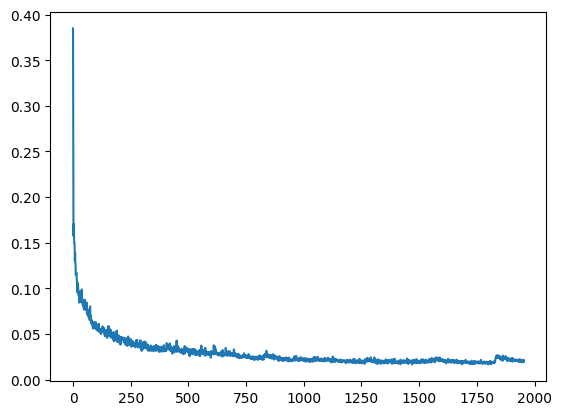

In [6]:
dataset_train = mnist_train
dataset_test = mnist_test

dataset_train = cifar10_train
dataset_test = cifar10_test

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=True)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

all_losses = []

for _ in range(5):
    for i, (data, target) in enumerate(tqdm(train_loader)):

        optimizer.zero_grad()

        data = data.to('cuda')

        # data = data.expand(-1, 3, -1, -1)
        # pad to 32x32
        # data = F.pad(data, (2, 2, 2, 2), value=0)
        # print(data.shape, target)
        # break
        x_hat = model(data)
        loss = loss_fn(x_hat, data)

        loss.backward()
        all_losses.append(loss.item())
        optimizer.step()

        if i % 100 == 0:
            # print(i, loss.item())
            # print the range of x_hat
            print(x_hat.min(), x_hat.max())
plt.plot(all_losses)



 13%|█▎        | 10/79 [00:00<00:04, 17.20it/s]


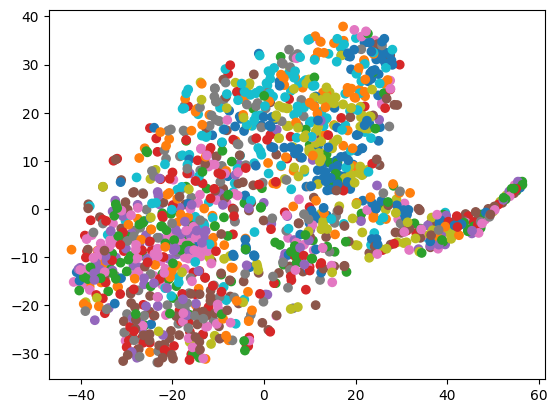

In [7]:
# do tsne on the encoder output
# get the encoder output
all_outputs = []
all_labels = []
for i, (data, target) in enumerate(tqdm(test_loader)):
    data = data.to('cuda')
    # data = data.expand(-1, 3, -1, -1)
    # data = F.pad(data, (2, 2, 2, 2), value=0)
    output = encoder(data).view(data.size(0), -1)
    # print range of output
    # print(output.min(), output.max())
    all_outputs.append(output.cpu().detach())
    all_labels.append(target)
    if i == 10:
        break

all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# do tsne
tsne = TSNE(n_components=2)
tsne_output = tsne.fit_transform(all_outputs)
plt.scatter(tsne_output[:, 0], tsne_output[:, 1], c=all_labels, cmap='tab10')
plt.show()
